In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torchvision
import torch.optim as optim
import torch.nn as nn

import cv2
import torch
import math

In [2]:
from loader import *

In [3]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [4]:
key_pts_frame = pd.read_csv('./data/training_frames_keypoints.csv')
a = key_pts = key_pts_frame.iloc[:, 1:].to_numpy()
kp_std = np.std(a)
kp_mean = np.mean(a)
print(f"Mean of keypoint: {kp_mean}")
print(f"STD of keypoint: {kp_std}")

Mean of keypoint: 104.4724870017331
STD of keypoint: 43.173022717543226


In [5]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                      root_dir='./data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (240, 240, 3) (68, 2)
1 (185, 160, 3) (68, 2)
2 (240, 320, 3) (68, 2)


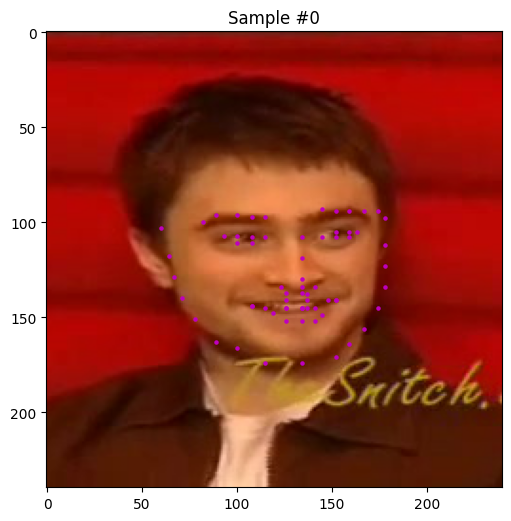

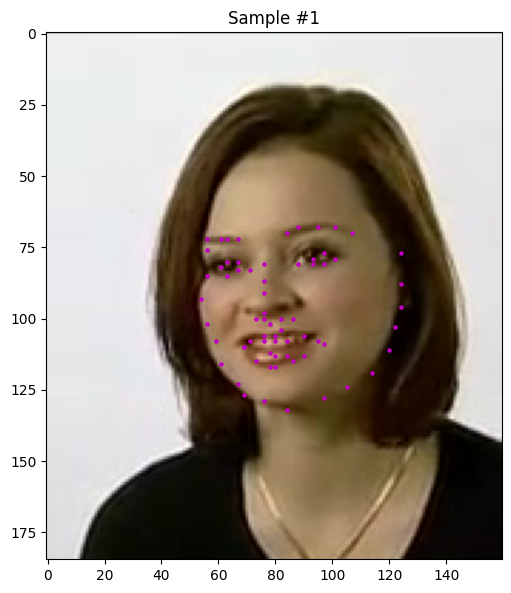

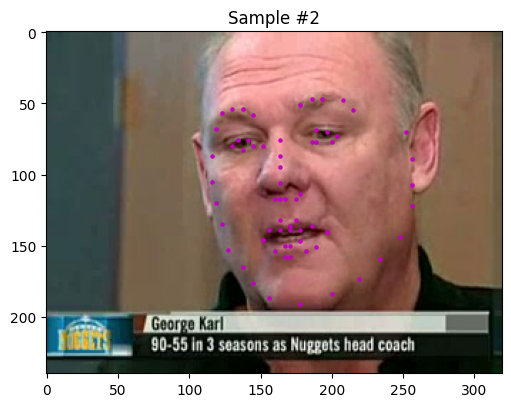

In [6]:
# Visualize samples from dataset

num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])

(113, 100, 3)
(174, 153, 3)
(174, 153, 3)
(174, 153, 3)


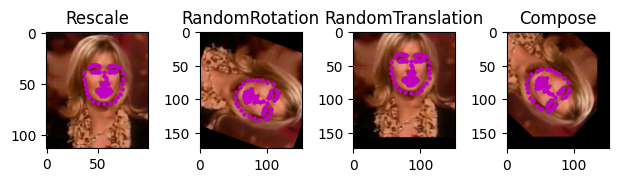

In [7]:
# visualize the different data augmentations

rescale = Rescale(100)
rotate = RandomRotation(180, 1.0)
translate = RandomTranslation((0.2,0.2), 1.0)
composed = transforms.Compose([RandomRotation(180, 1.0), RandomTranslation((0.2,0.2), 1.0)])

# apply the transforms to a sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, rotate, translate, composed]):
    transformed_sample = tx(sample)
    
    print(transformed_sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [24]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     RandomTranslation((0.2,0.2), 0.5),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)

In [9]:
# Default model

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision

# ## Once you've define the network, you can instantiate it
# # one example conv layer has been provided for you
# from model import Net

# net = Net().to('cuda')
# print(net)

In [25]:
# pretrained resnet18

model = torchvision.models.resnet18(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, 68*2)

model = model.type(torch.FloatTensor)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
net = model.to(device)

/home/davidyao99/miniconda3/envs/image_morph/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davidyao99/miniconda3/envs/image_morph/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [28]:
# test the model on a batch of test images
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images.cpu(), output_pts.cpu(), key_pts

In [29]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    
    # image is grayscale
    plt.imshow(image)
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

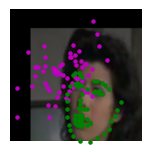

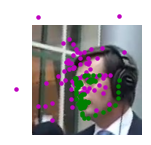

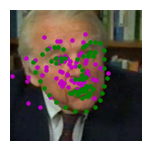

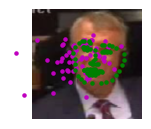

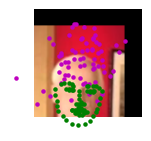

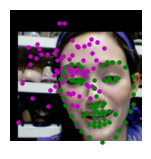

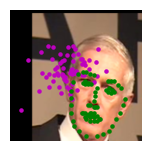

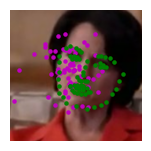

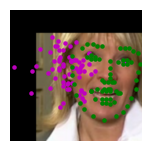

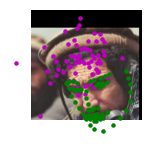

In [30]:
# visualize the output
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

In [32]:
## Define the loss and optimization

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [33]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    training_loss = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to('cuda')
            images = images.type(torch.FloatTensor).to('cuda')

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
        training_loss.append(running_loss)
        del images
        del key_pts
        torch.cuda.empty_cache()

    print('Finished Training')
    return training_loss

In [34]:
train_net(10)

Epoch: 1, Batch: 10, Avg. Loss: 0.49285953044891356
Epoch: 1, Batch: 20, Avg. Loss: 0.22296447455883026
Epoch: 1, Batch: 30, Avg. Loss: 0.11904869228601456
Epoch: 1, Batch: 40, Avg. Loss: 0.12206218615174294
Epoch: 1, Batch: 50, Avg. Loss: 0.099254385009408
Epoch: 1, Batch: 60, Avg. Loss: 0.0846364103257656
Epoch: 1, Batch: 70, Avg. Loss: 0.095154445245862
Epoch: 1, Batch: 80, Avg. Loss: 0.14560930505394937
Epoch: 1, Batch: 90, Avg. Loss: 0.07565707080066204
Epoch: 1, Batch: 100, Avg. Loss: 0.0786924660205841
Epoch: 1, Batch: 110, Avg. Loss: 0.06155350543558598
Epoch: 1, Batch: 120, Avg. Loss: 0.08682819083333015
Epoch: 1, Batch: 130, Avg. Loss: 0.07289590202271938
Epoch: 1, Batch: 140, Avg. Loss: 0.08058857079595327
Epoch: 1, Batch: 150, Avg. Loss: 0.10937773920595646
Epoch: 1, Batch: 160, Avg. Loss: 0.06900493986904621
Epoch: 1, Batch: 170, Avg. Loss: 0.07516826018691063
Epoch: 1, Batch: 180, Avg. Loss: 0.1561035342514515
Epoch: 1, Batch: 190, Avg. Loss: 0.10143421031534672
Epoch: 1,

Epoch: 8, Batch: 100, Avg. Loss: 0.012802050588652492
Epoch: 8, Batch: 110, Avg. Loss: 0.014463050011545419
Epoch: 8, Batch: 120, Avg. Loss: 0.014864491391927004
Epoch: 8, Batch: 130, Avg. Loss: 0.043261468317359685
Epoch: 8, Batch: 140, Avg. Loss: 0.08184967916458845
Epoch: 8, Batch: 150, Avg. Loss: 0.047869939170777795
Epoch: 8, Batch: 160, Avg. Loss: 0.027693809755146504
Epoch: 8, Batch: 170, Avg. Loss: 0.02498669233173132
Epoch: 8, Batch: 180, Avg. Loss: 0.024304865673184396
Epoch: 8, Batch: 190, Avg. Loss: 0.014717043517157436
Epoch: 8, Batch: 200, Avg. Loss: 0.12761327251791954
Epoch: 8, Batch: 210, Avg. Loss: 0.03802446182817221
Epoch: 9, Batch: 10, Avg. Loss: 0.024848949164152145
Epoch: 9, Batch: 20, Avg. Loss: 0.03729683356359601
Epoch: 9, Batch: 30, Avg. Loss: 0.08014956163242459
Epoch: 9, Batch: 40, Avg. Loss: 0.04870561398565769
Epoch: 9, Batch: 50, Avg. Loss: 0.024308157339692115
Epoch: 9, Batch: 60, Avg. Loss: 0.01821175180375576
Epoch: 9, Batch: 70, Avg. Loss: 0.01772798

[0.34267405793070793,
 0.3173441495746374,
 0.2521734721958637,
 0.17194199189543724,
 0.30683613382279873,
 0.2277497285977006,
 0.08762347092851996,
 0.1749481987208128,
 0.14136898517608643,
 0.13800553511828184]

In [17]:
# visualize the loss as the network trained
plt.figure()
plt.semilogy(training_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss');

NameError: name 'training_loss' is not defined

<Figure size 640x480 with 0 Axes>

In [18]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 3, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


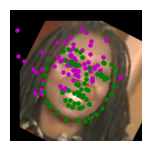

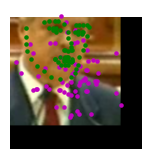

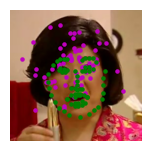

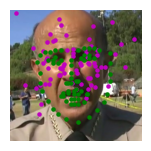

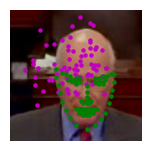

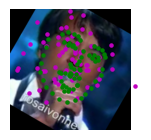

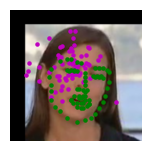

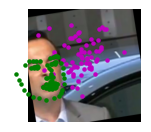

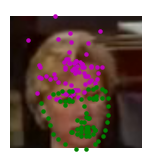

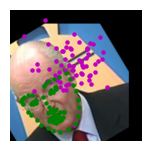

In [22]:
## visualize  test output
# you can use the same function as before, by un-commenting the line below:
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'resnet18_pretrain_model.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [21]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 68*2)
model = model.type(torch.FloatTensor)
net = model.to('cuda')
net.load_state_dict(torch.load('saved_models/resnet18_pretrain_model.pt'))

<All keys matched successfully>